# UBC OCEAN Classifier - Training 5x1024 Random Tiles - GPU Enabled 

* Issue with using pyvips on GPU resolved!
* See config for model architecture


# Config

In [1]:
class Config():
    tile_size = 1024
    seed = 12
    folds = 4
    epochs = 5
    arch = 'convnext_tiny_in22k'
    lr = .05
    
config = Config()

#arch = 'vit_small_patch16_224' # 'vit_base_patch16_224'
#arch = "microsoft/swin-tiny-patch4-window7-224"
#arch = 'swin_base_patch4_window7_224_in22k'
#arch = 'vit_base_patch16_224'
#arch = 'convnext_tiny_in22k'

# Installs

In [3]:
# For IEEE style plotting
!pip install /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl

Processing /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl


In [4]:
# !ls /kaggle/input/pyvips-python-and-deb-package

# !dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb

# !pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index
# !pip list | grep pyvips

#!sudo apt-get update
#!sudo apt-get install -y libvips


In [5]:
#!pip install -q pyvips

# Imports

In [6]:
import fastai
from fastai.vision.all import *
fastai.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.7.12'

In [7]:
import os
import gc
import shutil
from glob import glob
from os import path

import cv2
import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','no-latex'])
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

# import pyvips
# pyvips.__version__

# Load Data

* There are four folders, train_images, train_thumbnails, test_images, test_thumbnails
    * There are 538 files in the train images folder, and 513 in the train_thumbnails folder
    * There is only one file in each of the test images/thumbnails folders.  It has the same label (41).
* There are three csv files, train, test, and sample_submission

Why do we have the thumbnails...to make training faster?

In [8]:
top_dir = '/kaggle/input/UBC-OCEAN'
new_train_dir = '/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled'

train = pd.read_csv(top_dir + '/train.csv')
test = pd.read_csv(top_dir + '/test.csv')
ss = pd.read_csv(top_dir + '/sample_submission.csv')

## Train/Test Csv files EDA

In [9]:
print(f'Size of training data: {train.shape}')
display(train.head())
display(test.head())

Size of training data: (538, 5)


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


,image_id,image_width,image_height
0,41,28469,16987


## Label Distribution

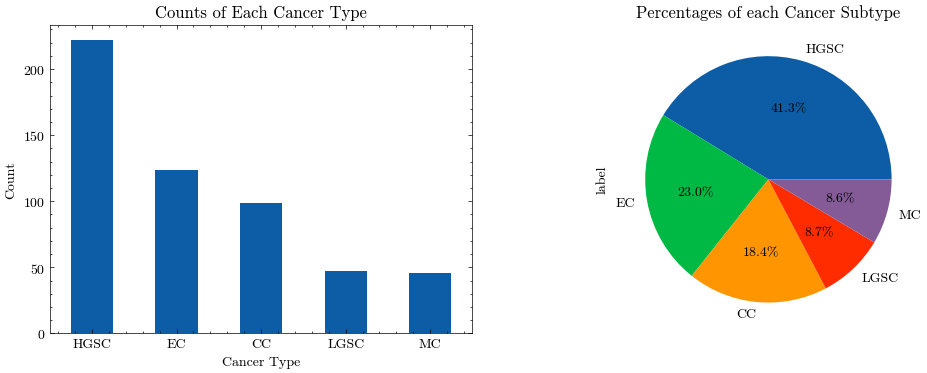

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train['label'].value_counts().plot(kind='bar', xlabel='Cancer Type', ylabel='Count', rot=0)
plt.title('Counts of Each Cancer Type')
plt.subplot(1,2,2)
train['label'].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label")
plt.title('Percentages of each Cancer Subtype');

## Add new path to images 
* With 512 pixel center tiles
* remove empty images better since implemented retries

## Make a list of files and remove empty images

In [ ]:
# make a list of all files in the dataset
train_files = glob(new_train_dir + '/**/*.png',recursive=True)
train_files = [file for file in train_files if '__results' not in file]  # will fix this on the next dataset

In [11]:
# helper function to compute percent saturation
def percent_saturation(im):

    tot_pixels = config.tile_size**2
    #print(f'total pixels: {tot_pixels}')
    tot_intensity = im.sum()/(255*3)
    percent_intensity = 100*tot_intensity/tot_pixels
    #print(f'File {file.split("/")[-1]}, Percent intensity = {percent_intensity:.2f}%')
    
    return percent_intensity


In [20]:
#ints = []
fails = []
for file in train_files:
    # open file
    im = cv2.imread(file)
    
    # compute intensity
    p = percent_saturation(im)
    if p > 87.5 or p < 12.5:
        fails.append(p)
        train_files.remove(file)
    
        
len(train_files)

# orig train files: 2690
# orig training: 0 zeros, 128 > 87.5, total = 2569

2569

(array([  6.,  14.,  30.,  64., 216., 638., 942., 587., 170.,  23.]),
 array([49.93994869, 54.49382262, 59.04769656, 63.60157049, 68.15544443,
        72.70931836, 77.2631923 , 81.81706623, 86.37094016, 90.9248141 ,
        95.47868803]),
 <BarContainer object of 10 artists>)

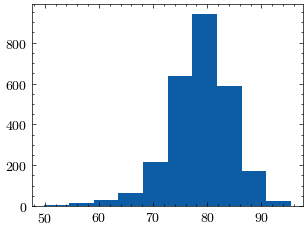

In [15]:
#plt.hist(ints)

(array([39., 34., 16., 14.,  4.,  2.,  1.,  3.,  1., 12.]),
 array([87.51501507, 88.31138237, 89.10774966, 89.90411696, 90.70048426,
        91.49685155, 92.29321885, 93.08958615, 93.88595344, 94.68232074,
        95.47868803]),
 <BarContainer object of 10 artists>)

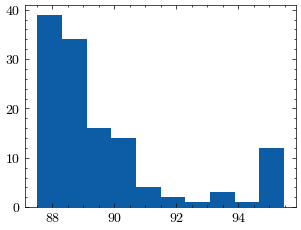

In [19]:
#plt.hist(fails)

## Create Dataframe from train_file list, with label column

In [21]:
img_ids, labels = [],[]

for file in train_files:
    img_ids.append(file.split('/')[-1].split('_')[0])
    labels.append(file.split('/')[-2])

data = list(zip(img_ids,labels,train_files))
            
new_train = pd.DataFrame(data,columns=['img_id','label','img_path'])
new_train.head()

,img_id,label,img_path
0,11557,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/11557_0.png
1,33976,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/33976_2.png
2,37385,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/37385_0.png
3,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_0.png
4,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_2.png


<Axes: xlabel='label'>

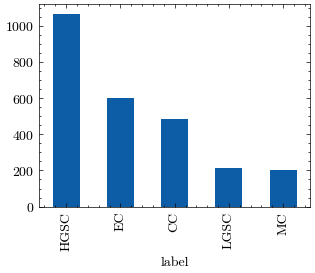

In [22]:
new_train.label.value_counts().plot(kind='bar')

# Model
* Currently using Fastai
    * Try some others later if have time, otherwise just hammer on fastai with different architectures

## Fastai Model Setup

In [23]:
from fastai.vision.all import *
import timm

In [24]:
from sklearn.model_selection import StratifiedKFold
num_folds = config.folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=12)

In [25]:
%%time
preds = []
acc_val = []
#epochs = 5
#lr = .035
#arch = 'vit_small_patch16_224' # 'vit_base_patch16_224'
#arch = "microsoft/swin-tiny-patch4-window7-224"
#arch = 'swin_base_patch4_window7_224_in22k'
#arch = 'vit_base_patch16_224'
#arch = 'convnext_tiny_in22k'

fold = 1

for train_index,val_index in skf.split(new_train.index,new_train['label']):
    
    # get set validation true/false column
    v = []
    for i in range(new_train.shape[0]):
        if i in val_index:
            v.append(True)
        else:
            v.append(False)

    new_train['validation'] = v

    # create a dataloader
#     dls = ImageDataLoaders.from_df(df, path, valid_col='validation',fn_col='image', label_col='label',
#                                    item_tfms=Resize(280), 
#                                    batch_tfms=aug_transforms(size=224, flip_vert=True))#.split_by_idxs(train_idx=train_index, valid_idx=val_index)
    
    dls = ImageDataLoaders.from_df(new_train,path='/',valid_col='validation',fn_col='img_path', label_col='label', seed=12,
                                   #item_tfms=Resize(280, method='squish'),
                                   item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                                   #batch_tfms=aug_transforms(size=224, max_rotate=180)
                                   )
                                                                    
#     dls = DataBlock(
#                     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#                     get_items = get_image_files,   #returns a list of all images files path
#                     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#                     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#                     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
#                     ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.
    
    
    learn = vision_learner(dls, config.arch, metrics=accuracy, path='.').to_fp16()  # vision transformer
    learn.fine_tune(config.epochs, config.lr)
    loss,acc = learn.validate()
    acc_val.append([loss,acc])
    
    #tst_dl = dls.test_dl(tst_files)
    # We will use test time augmentation...
    #tta_preds,_ = learn.tta(dl=tst_dl)
    
    #preds.append(tta_preds)
    # get max probability per row....later I think
    # pred_idxs = tta_preds.argmax(dim=1)
    
    fold +=1
    
    gc.collect()
    
# with arch = 'vit_base_patch16_224', lb = .25
# with 'vit_small_patch16_224'

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.383410,2.927473,0.435459,01:13


epoch,train_loss,valid_loss,accuracy,time
0,1.713259,1.492308,0.544324,01:14
1,1.521539,1.499447,0.581649,01:14
2,1.210228,1.235691,0.614308,01:15
3,0.832544,1.046062,0.682737,01:14
4,0.553535,0.941712,0.698289,01:15


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.325111,3.190972,0.504673,01:12


epoch,train_loss,valid_loss,accuracy,time
0,1.726805,1.539113,0.560748,01:14
1,1.515785,1.837612,0.549844,01:14
2,1.236137,1.341942,0.629283,01:15
3,0.884872,0.940159,0.710280,01:16
4,0.610471,0.891409,0.713396,01:15


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.234232,2.871464,0.500000,01:14


epoch,train_loss,valid_loss,accuracy,time
0,1.732875,2.104511,0.542056,01:13
1,1.472741,1.968952,0.524922,01:15
2,1.203192,1.323031,0.587227,01:15
3,0.864692,1.011770,0.707165,01:14
4,0.576426,0.939524,0.713396,01:14


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,accuracy,time
0,2.347666,2.746169,0.367601,01:13


epoch,train_loss,valid_loss,accuracy,time
0,1.730960,2.032022,0.554517,01:11
1,1.526094,2.257073,0.431464,01:03
2,1.217748,1.415732,0.574766,01:02
3,0.878317,0.936919,0.710280,01:02
4,0.585419,0.926149,0.708723,01:02


CPU times: user 11min 18s, sys: 3min 14s, total: 14min 32s
Wall time: 30min 29s


In [ ]:
# above is training on .025 lr with 1024 images

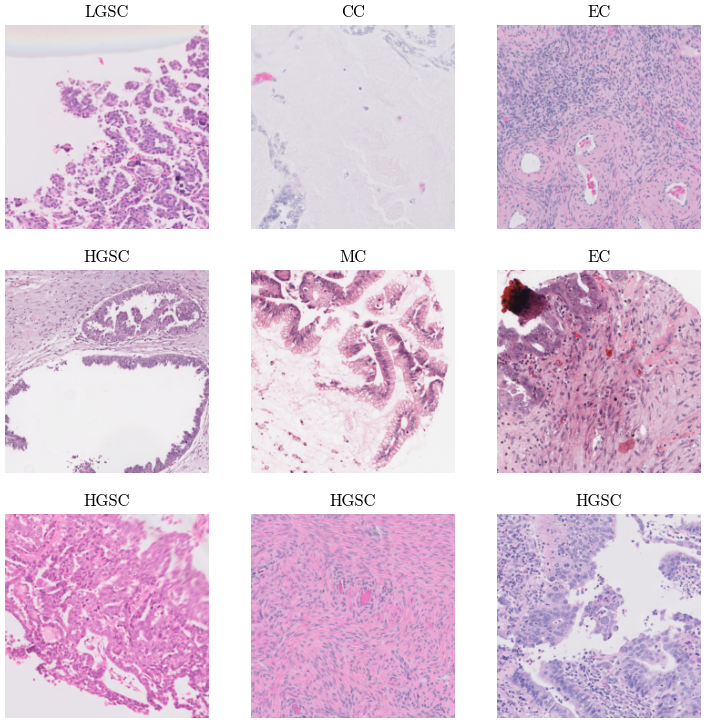

In [26]:
# how I did it with the snakes classifier

# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#     get_items = get_image_files,   #returns a list of all images files path
#     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
# ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.

dls.show_batch(max_n=9) # shows the input (picture) and the label


In [27]:
# learn = vision_learner(dls,resnet18,metrics=error_rate)
# learn.fine_tune(3)

In [28]:
# #learn.lr_find(suggest_funcs=(valley, slide))
# loss,acc = learn.validate()
learn.dls.vocab

['CC', 'EC', 'HGSC', 'LGSC', 'MC']

In [29]:
acc_val = np.array(acc_val)
acc_val

array([[0.94171226, 0.69828928],
       [0.89140934, 0.71339566],
       [0.93952358, 0.71339566],
       [0.92614871, 0.70872277]])

In [30]:
mean_acc = np.mean(acc_val[:,1])
mean_loss = np.mean(acc_val[:,0])
print(f'Model {config.arch}, learning rate: {config.lr}, epochs: {config.epochs}' )
print(f'Mean acc is: {np.mean(acc_val[:,1]):.5f}, Mean Loss is {np.mean(acc_val[:,0]):.3f}, std is: {np.std(acc_val[:,1]):.5f}')

# mean .53883 with no scaling
# Mean is .44932 next run (.05 lr)...This verifies that randomness is greater for scores than scaling, but do another
# still lr =.05, mean is .48695
# again, .47521 (this just doesn't seem like a great optimized solution)
# try .01, .50498, looks like this set has worse images

Model convnext_tiny_in22k, learning rate: 0.05, epochs: 5
Mean acc is: 0.70845, Mean Loss is 0.925, std is: 0.00617


In [31]:
# save so I can infer in the next notebook.  downloaded this file 11/14/23 3:38pm
learn.export(fname=f'5x1024_no_sat_tma2x_{config.arch}_{config.epochs}_epochs_{config.lr}_lr_{mean_acc:.4f}_{mean_loss:.4f}.pkl')